# British Columbia Hydraulic Fracturing Water Use Analysis  
![Hydraulic fracturing activity in British Columbia](../data/images/image1.jpg)

## Overview  
This notebook analyzes **hydraulic fracturing water use in British Columbia** using publicly available **FracFocus records published by the British Columbia Energy Regulator (BCER)**.

FracFocus data is reported at the **ingredient level**, which means a single fracture event may appear across **multiple rows** (one row per ingredient). Because the research question here is about **water use**, the workflow focuses on converting the raw ingredient-level table into a **fracture-event dataset** that can be summarized over time, compared across regions, and mapped.

## Objectives  
The goals of this analysis are to:
- Quantify **reported water volumes** used during hydraulic fracturing events  
- Identify **trends over time** using simple annual summaries  
- Summarize water use patterns by **region / well area**  
- Demonstrate a clear, reproducible workflow for **data cleaning → validation → analysis → visualization**

This case study prioritizes **data handling, interpretation, and communication** rather than advanced modeling.

## Data Source  
- **Dataset:** BIL-183 — Complete FracFocus Data (BC)  
- **Publisher:** British Columbia Energy Regulator (BCER)  
- **Format:** CSV (public regulatory dataset)

## Key Assumptions (for this notebook)  
- **Total Water Volume (m³)** represents the reported water injected per fracture event.  
- To avoid double-counting, fracture events are aggregated to **one record per unique event** (using **UWI + Fracture Date**).  
- Results reflect **reported fracturing activity** only and do not represent full lifecycle water use (sourcing, reuse, disposal).

## Scope and Limitations  
This notebook focuses on:
- Reported **fracturing water volumes**
- **Temporal trends**
- **Regional summaries** by well area
- **Spatial visualization** using reported coordinates

It does not evaluate:
- Chemical composition of fluids
- Recycling/disposal practices
- Environmental impacts beyond reported volumes


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 5)
print("Notebook ready")

Notebook ready


## Load Raw BCER FracFocus Dataset (Ingredient-Level)

The BCER FracFocus dataset is provided at the **ingredient level**. That means:
- A single fracture event (same well + same fracture date) can appear across **many rows**
- **Total Water Volume (m³)** may be repeated across those rows
- Directly summing water volume from the raw file would **over-count** total water use

Before cleaning the dataset, the next step is a quick **raw data exploration** to confirm the structure, understand duplication, and identify the fields needed for analysis and mapping.


In [2]:
DATA_PATH = Path("../data/raw")
csv_file = DATA_PATH / "Fracture Fluid Data.csv"

df = pd.read_csv(
    csv_file,
    encoding="latin1",   # handles Windows-encoded characters
    low_memory=False
)
df.head()


Fracture Date  WA Number Well Area Name Operator  \
0   05-DEC-2025      51894           INGA   ARCRES   
1   05-DEC-2025      51894           INGA   ARCRES   
2   05-DEC-2025      51894           INGA   ARCRES   
3   05-DEC-2025      51894           INGA   ARCRES   
4   05-DEC-2025      51894           INGA   ARCRES   

                       Well Name     Latitude     Longitude               UWI  \
0  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
1  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
2  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
3  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
4  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   

                   Trade Name              Supplier           Purpose  \
0  SFR-400 (Friction Reducer)  STEP Energy Services  Friction Reducer   
1  SFR-400 (Friction Reducer)  STEP Energy Services  Friction Reducer   
2                      SIC-3N  STEP Energy Services     Iron Chelator   
3                      SIC-3N  STEP Energy Services     Iron Chelator   
4                     SIC-3NL  STEP Energy Services     Iron Chelator   

  CAS Number Ingredient Comments Ingredient Name  \
0  9003-05-8                 NaN  Polyacrylamide   
1  9003-05-8                 NaN  Polyacrylamide   
2          -                 NaN     Undisclosed   
3          -                 NaN     Undisclosed   
4          -                 NaN     Undisclosed   

   Ingredient Concentration in HF Fluid % by Mass  \
0                                          0.0569   
1                                          0.0569   
2                                          0.0003   
3                                          0.0003   
4                                          0.0093   

   Ingredient Percentage in Additive by % Mass  Total Water Volume (m^3)  
0                                        100.0                  53074.54  
1                                        100.0                  53074.54  
2                                        100.0                  53074.54  
3                                        100.0                  53074.54  
4                                        100.0                  53074.54

## Raw Data Exploration (Before Cleaning)

This section validates what the raw file contains and why cleaning is required.

We check:
- The dataset shape (rows/columns)
- Column names and basic data types
- Whether events repeat across multiple rows (ingredient-level duplication)
- The presence and format of key fields needed later:
  - Fracture Date
  - UWI (well identifier)
  - Well Area Name (regional grouping)
  - Latitude / Longitude (for mapping)
  - Total Water Volume (m³)

These checks help confirm that aggregation is necessary and guide the design of the cleaning script.


In [3]:
df.shape, df.columns
df.dtypes
# Quick duplication check: how many rows per (UWI, Fracture Date)?
event_counts = df.groupby(["UWI", "Fracture Date"]).size().sort_values(ascending=False)
event_counts.head(10)
# This one here is to Confirm if Total Water Volume repeats within an event
sample_event = event_counts.index[0]
df[(df["UWI"] == sample_event[0]) & (df["Fracture Date"] == sample_event[1])][
    ["UWI", "Fracture Date", "Ingredient Name", "Total Water Volume (m^3)"]
].head(10)


UWI Fracture Date                 Ingredient Name  \
102553  203B076F094B1600   20-JUL-2016                Potassium oleate   
102554  203B076F094B1600   20-JUL-2016                Potassium oleate   
102555  203B076F094B1600   20-JUL-2016                Potassium oleate   
102556  203B076F094B1600   20-JUL-2016  Decamethyl cyclopentasiloxane    
102557  203B076F094B1600   20-JUL-2016  Decamethyl cyclopentasiloxane    
102558  203B076F094B1600   20-JUL-2016  Decamethyl cyclopentasiloxane    
102559  203B076F094B1600   20-JUL-2016                Sodium hydroxide   
102560  203B076F094B1600   20-JUL-2016                Sodium hydroxide   
102561  203B076F094B1600   20-JUL-2016                Sodium hydroxide   
102562  203B076F094B1600   20-JUL-2016              Copper(II) sulfate   

        Total Water Volume (m^3)  
102553                   10773.4  
102554                   10773.4  
102555                   10773.4  
102556                   10773.4  
102557                   10773.4  
102558                   10773.4  
102559                   10773.4  
102560                   10773.4  
102561                   10773.4  
102562                   10773.4

## Runing the Data Cleaning Script 

The raw file cannot be analyzed directly for total water use because fracture events appear across multiple ingredient rows.

The cleaning script performs the following high-level steps:
- Loads the raw CSV using a safe encoding
- Standardizes data types (date parsing, numeric water volume)
- Converts coordinates into **decimal degrees** for mapping
- Removes rows missing required analysis fields
- Aggregates to **one row per fracture event** (UWI + Fracture Date) to avoid double-counting
- Writes a cleaned dataset to `data/cleaned/fracture_events_cleaned.csv`
The screenshot below shows the script being run successfully and confirms that the cleaned fracture-event dataset was generated without errors.

![Data cleaning script execution](../data/images/image2.png)

From this point onward, the analysis uses the cleaned **event-level** dataset where **each row represents one fracture event**.



### Load Cleaned Fracture Event Dataset

After running the data cleaning script, the analysis proceeds using the cleaned, aggregated fracture-event dataset.

At this stage of the workflow:

- Each row represents a single hydraulic fracturing event  
- Ingredient-level duplication has been removed  
- Total water volumes are no longer double-counted  
- Latitude and longitude coordinates are available in decimal degrees for spatial analysis and mapping  

This cleaned dataset forms the foundation for all subsequent validation, summary statistics, visualizations, and spatial analysis.


In [4]:
clean_file = Path("../data/cleaned/fracture_events_cleaned.csv")

events = pd.read_csv(
    clean_file,
    parse_dates=["Fracture Date"]
)

events.head()


Fracture Date  Year               UWI Well Area Name  Latitude_dd  \
0    2025-12-05  2025  100123508424W600           INGA    56.312978   
1    2025-12-05  2025  100133508424W600           INGA    56.313036   
2    2025-12-05  2025  100143508424W600           INGA    56.313094   
3    2025-12-05  2025  100020208524W600           INGA    56.313156   
4    2025-11-25  2025  100113607917W600        SUNRISE    55.894325   

   Longitude_dd  Total Water Volume (m^3)  
0   -121.652242                  53074.54  
1   -121.652119                  51230.95  
2   -121.651997                  52685.17  
3   -121.651878                  52505.73  
4   -120.520197                    407.90

### Data Validation and Quality Checks

Before conducting any analysis, I did validation checks are performed on the cleaned dataset to confirm that it is complete, consistent, and suitable for analysis.

The checks focus on:

- Confirming the expected number of fracture events  
- Ensuring no missing values in critical fields (date, water volume, coordinates)  
- Verifying that reported water volumes fall within reasonable operational ranges  


In [5]:
events.shape


(6500, 7)

In [6]:
events.isna().sum()


Fracture Date               0
Year                        0
UWI                         0
Well Area Name              0
Latitude_dd                 0
Longitude_dd                0
Total Water Volume (m^3)    0
dtype: int64

In [7]:
events["Total Water Volume (m^3)"].describe()


count      6500.000000
mean      17278.755471
std       13876.867206
min           0.000000
25%        9502.970000
50%       14227.500000
75%       21557.875000
max      170945.200000
Name: Total Water Volume (m^3), dtype: float64

Based on these validation checks, the cleaned dataset is considered complete and suitable for analysis.

No missing values were identified in critical fields, and the total number of fracture events aligns with expectations following aggregation. Reported water volumes fall within ranges consistent with large-scale hydraulic fracturing operations in British Columbia.

With these checks complete, the analysis proceeds to summary statistics, trend analysis, visualizations, and spatial mapping using this cleaned event-level dataset.


## Summary Statistics and Trends

This section summarizes hydraulic fracturing water use in British Columbia using descriptive statistics and structured aggregation.

The analysis focuses on:
- How total and average water use changes over time
- How water use is distributed across regions
- Whether total water demand is driven evenly across fracture events or concentrated among a smaller number of high-volume operations


### Annual Water Use Summary

To examine how hydraulic fracturing activity changes over time, water use is aggregated by year. For each year, the number of fracture events, total reported water volume, and average water volume per event are calculated.


In [8]:
by_year = (
    events
    .groupby("Year")["Total Water Volume (m^3)"]
    .agg(
        fracture_events="count",
        total_water_m3="sum",
        avg_water_m3="mean"
    )
    .reset_index()
    .sort_values("Year")
)

by_year

by_year.style.format({
    "total_water_m3": "{:,.0f}",
    "avg_water_m3": "{:,.0f}"
})



### Interpretation of Annual Water Use Trends

The annual summary shows that hydraulic fracturing water use in British Columbia varies substantially over time, influenced by both the number of fracture events and changes in average water volume per event.

From 2011 through the mid-2010s, total water use increases as fracturing activity expands. While event counts fluctuate year to year, average water volume per event shows a clear upward trend beginning around 2019.

In more recent years, total water use remains high even when fracture event counts decline, indicating that individual fracture operations are becoming increasingly water-intensive. This pattern is consistent with longer horizontal wells and more complex multi-stage fracturing practices.


### Regional Summary of Water Use

To understand how hydraulic fracturing water use is distributed spatially, fracture events are aggregated by well area. This highlights which regions account for the largest share of total water use and whether differences are driven by activity levels or by water intensity per event.


In [9]:
by_area = (
    events
    .groupby("Well Area Name")["Total Water Volume (m^3)"]
    .agg(
        fracture_events="count",
        total_water_m3="sum",
        avg_water_m3="mean"
    )
    .reset_index()
    .sort_values("total_water_m3", ascending=False)
)

by_area.head(10)


Well Area Name  fracture_events  total_water_m3   avg_water_m3
128        SUNRISE              762    1.192363e+07   15647.809767
141           TOWN              663    1.141177e+07   17212.329585
8          ALTARES              431    9.591647e+06   22254.400745
22       BLUEBERRY              119    4.722734e+06   39686.838588
75            INGA              170    4.713783e+06   27728.137741
54             DOE              339    4.046470e+06   11936.489344
122       SEPTIMUS              262    3.867980e+06   14763.282941
67     GROUNDBIRCH              261    3.460049e+06   13256.892567
80        KIWIGANA               32    3.311117e+06  103472.398125
127        SUNDOWN              225    3.097528e+06   13766.791404

### Interpretation of Regional Water Use Patterns

Hydraulic fracturing water use in British Columbia is highly concentrated within a small number of well areas. Regions such as SUNRISE and TOWN contribute the largest share of total water use, primarily due to high numbers of fracture events.

Other areas, including ALTARES, BLUEBERRY, and INGA, show fewer fracture events but substantially higher average water volumes per event. This indicates that regional differences in total water use are driven not only by activity levels, but also by variations in well design and operational intensity.

Overall, provincial water use impacts are unevenly distributed, with a limited number of regions accounting for a disproportionate share of total fracturing-related water demand.


### Water Use Concentration Across Fracture Events

Not all fracture events contribute equally to total water use.
To quantify concentration, fracture events are ranked by Total Water Volume (m³) and we calculate:

- How much of total water use is explained by the top 10% of events

- A cumulative contribution curve showing whether water demand is spread evenly or dominated by a smaller set of high-volume events

This helps distinguish “many moderate events” vs “few high-intensity events” driving overall water demand.


In [10]:
events_ranked = (
    events
    .sort_values("Total Water Volume (m^3)", ascending=False)
    .reset_index(drop=True)
)

events_ranked["event_share"] = (events_ranked.index + 1) / len(events_ranked)
events_ranked["water_share"] = (
    events_ranked["Total Water Volume (m^3)"].cumsum()
    / events_ranked["Total Water Volume (m^3)"].sum()
)

top_10_index = int(0.10 * len(events_ranked)) - 1
top_10_water_share = events_ranked.loc[top_10_index, "water_share"]

top_10_water_share


np.float64(0.2726723711467533)

### Interpretation of Water Use Concentration

The results show that the largest 10% of fracture events account for a substantial share of total reported hydraulic fracturing water use.

This indicates that water demand is not evenly distributed across fracture operations. Instead, a relatively small number of high-volume events contribute disproportionately to overall water use.

From a planning and policy perspective, this suggests that changes in operational practices for a limited number of high-intensity fracture events can have a meaningful impact on total provincial water demand.


## Visualizations

This section presents a focused set of visualizations to support the summary statistics and key findings. Each chart is directly tied to a specific analytical question and is designed to emphasize interpretability over visual complexity.

The visualizations address the following questions:
- How does total hydraulic fracturing water use change over time?
- Which regions account for the largest share of water use?
- How does fracturing activity relate to water-use intensity across regions?
- How is water volume distributed across individual fracture events?
- Is total water use concentrated among a small number of high-volume events?

### Total Water Use Over Time (Annual)

This chart shows total reported hydraulic fracturing water volume aggregated by year.


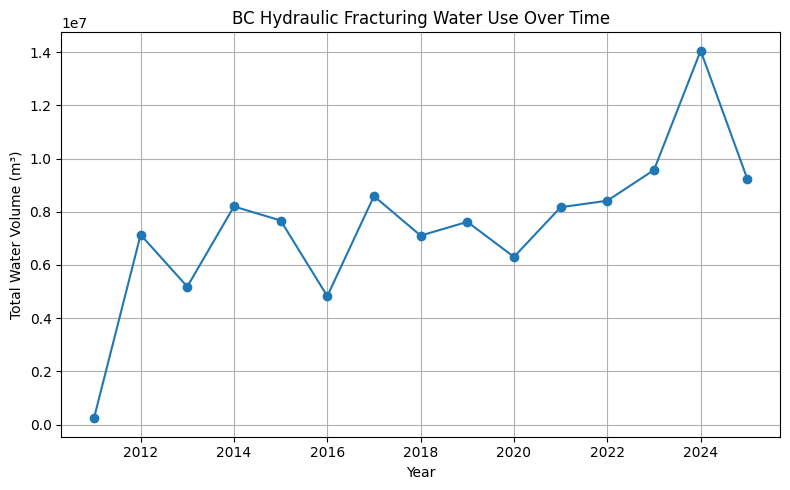

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(by_year["Year"], by_year["total_water_m3"], marker="o")
plt.xlabel("Year")
plt.ylabel("Total Water Volume (m³)")
plt.title("BC Hydraulic Fracturing Water Use Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Annual Water Use Trend

This visualization shows total reported hydraulic fracturing water use in British
Columbia by year. While annual totals fluctuate, the overall pattern indicates
increasing water use over time, with notably higher volumes in recent years.

The upward trend in later years suggests that, despite variability in the number
of fracture events, individual operations are using larger volumes of water on
average. This is consistent with the continued development of longer horizontal
wells and more intensive multi-stage fracturing practices.


### Top Well Areas by Total Water Use

This chart highlights the well areas that contribute the largest share of total water use.


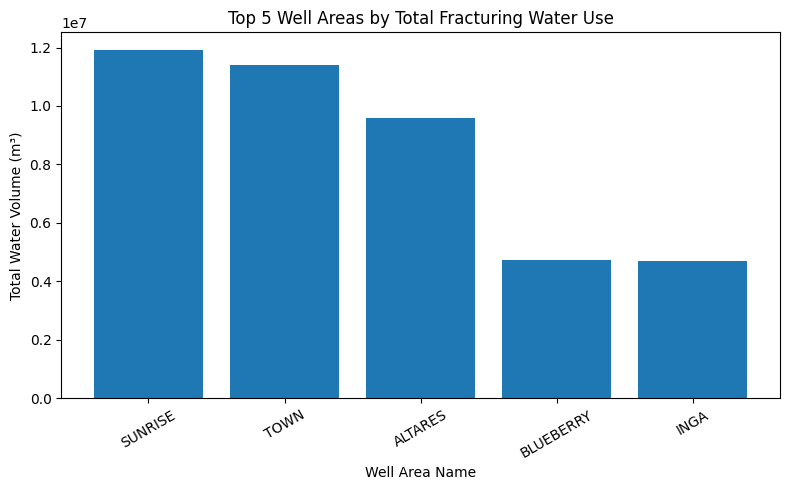

In [12]:
top_regions = by_area.head(5)
plt.figure(figsize=(8, 5))
plt.bar(top_regions["Well Area Name"], top_regions["total_water_m3"])
plt.xlabel("Well Area Name")
plt.ylabel("Total Water Volume (m³)")
plt.title("Top 5 Well Areas by Total Fracturing Water Use")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### Interpretation of Top Well Areas by Water Use

This chart shows that hydraulic fracturing water use in British Columbia is concentrated
within a small number of well areas. **SUNRISE** and **TOWN** account for the largest
share of total water use, reflecting both high levels of fracturing activity and sustained
development in these regions.

Other areas such as **ALTARES**, **BLUEBERRY**, and **INGA** contribute smaller but still
significant portions of total water use, indicating that water demand is not evenly
distributed across the province. Overall, the results highlight a regional concentration
of water-intensive operations rather than uniform usage across all well areas.


### Activity vs Intensity by Region

This scatter plot compares the number of fracture events in each well area to the average
water volume per event. It helps distinguish areas dominated by many events versus fewer,
more water-intensive events.


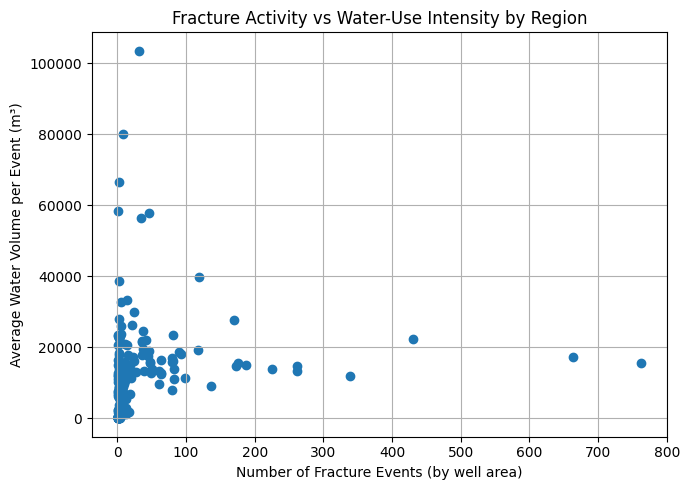

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(by_area["fracture_events"], by_area["avg_water_m3"])
plt.xlabel("Number of Fracture Events (by well area)")
plt.ylabel("Average Water Volume per Event (m³)")
plt.title("Fracture Activity vs Water-Use Intensity by Region")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Activity vs. Water-Use Intensity

The distribution is strongly right-skewed, with most fracture events using moderate volumes of water and a smaller number of events using substantially higher volumes. These high-volume events contribute disproportionately to total water demand and help explain year-to-year variability in aggregate water use.


### Distribution of Water Volume per Fracture Event

This histogram shows how water volume is distributed across fracture events and whether
the data contains a long tail of high-volume events.


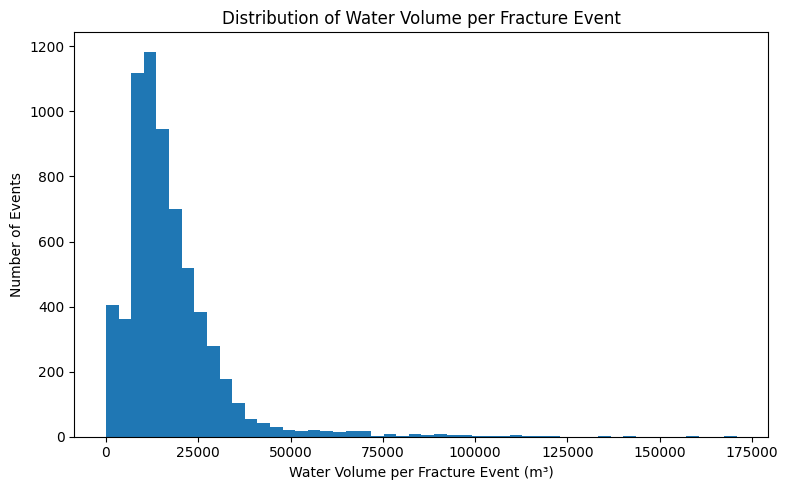

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(events["Total Water Volume (m^3)"], bins=50)
plt.xlabel("Water Volume per Fracture Event (m³)")
plt.ylabel("Number of Events")
plt.title("Distribution of Water Volume per Fracture Event")
plt.tight_layout()
plt.show()


### Interpretation of Water Volume Distribution

The distribution of water volume per fracture event is strongly right-skewed, with the
majority of fracture events using relatively moderate volumes of water and a smaller
number of events using substantially higher volumes.

This long-tailed distribution indicates that while typical fracturing operations cluster
around a common range of water use, a limited number of large or highly intensive
operations contribute disproportionately to overall water demand. These high-volume
events help explain year-to-year variability in total water use.


### Cumulative Water Use Over Time

This chart shows cumulative reported water use over time, which reduces year-to-year noise
and highlights long-term growth in total water demand from fracturing activity.


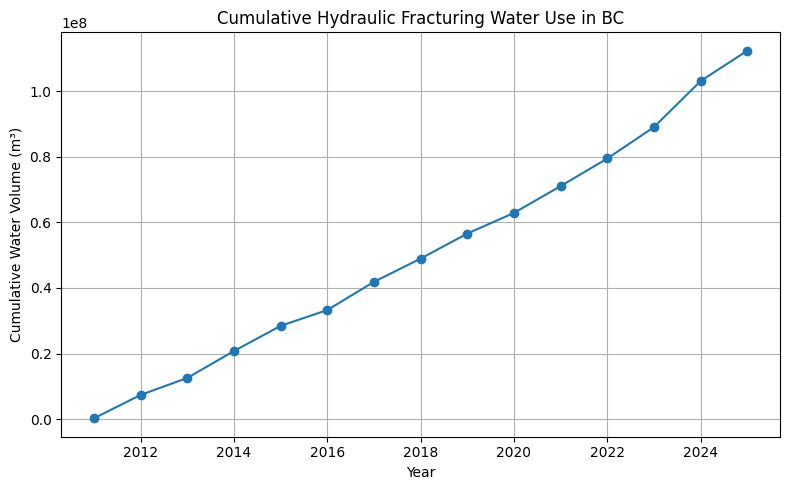

In [15]:
by_year = by_year.copy()
by_year["cumulative_water_m3"] = by_year["total_water_m3"].cumsum()

plt.figure(figsize=(8, 5))
plt.plot(by_year["Year"], by_year["cumulative_water_m3"], marker="o")
plt.xlabel("Year")
plt.ylabel("Cumulative Water Volume (m³)")
plt.title("Cumulative Hydraulic Fracturing Water Use in BC")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Cumulative Water Use

The cumulative water use curve shows a steady increase in total reported hydraulic
fracturing water use over time. Unlike annual totals, the cumulative view smooths
short-term variability and highlights long-term growth in overall water demand.

The consistently upward trajectory indicates that water use from fracturing activity
has accumulated substantially over the study period, with more recent years contributing
a larger share of the total. This reinforces the observation tha


### Concentration of Water Use Across Fracture Events

This visualization examines how total water use accumulates as fracture events are ranked from smallest to largest by water volume.


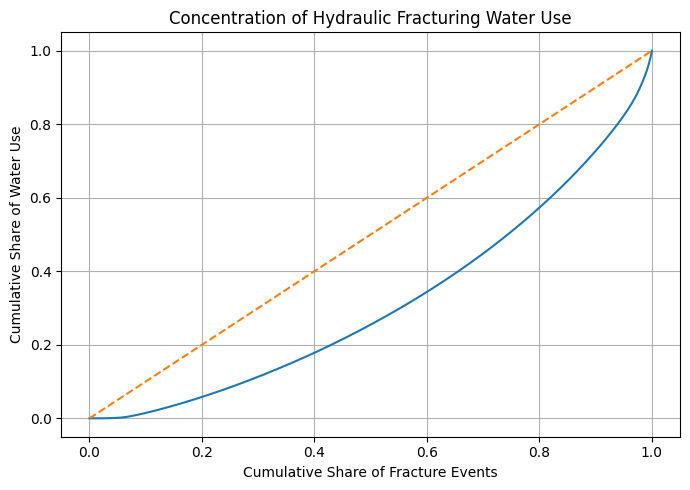

In [16]:
events_ranked = (
    events
    .sort_values("Total Water Volume (m^3)")
    .reset_index(drop=True)
)

events_ranked["event_share"] = (events_ranked.index + 1) / len(events_ranked)
events_ranked["water_share"] = (
    events_ranked["Total Water Volume (m^3)"].cumsum()
    / events_ranked["Total Water Volume (m^3)"].sum()
)

plt.figure(figsize=(7, 5))
plt.plot(events_ranked["event_share"], events_ranked["water_share"])
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Cumulative Share of Fracture Events")
plt.ylabel("Cumulative Share of Water Use")
plt.title("Concentration of Hydraulic Fracturing Water Use")
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation**  
The curve deviates strongly from an equal-distribution reference, indicating that total water use is highly concentrated among a relatively small number of fracture events. A minority of high-volume operations account for a disproportionate share of total reported water use, highlighting the importance of event-level intensity in driving overall water demand.

### Mapping Individual Fracture Events

Each point on the map represents a single reported hydraulic fracturing event.
Marker size is scaled by total reported water volume to visually distinguish
lower- and higher-intensity operations.

This view helps identify:
- Spatial clustering of fracture activity
- Areas with consistently higher water use
- The geographic footprint of hydraulic fracturing in northeast British Columbia


In [17]:
water_col = None
for c in events.columns:
    if "Total Water Volume" in c:
        water_col = c
        break

water_col

'Total Water Volume (m^3)'

## Mapping Visualizations

Two complementary spatial representations are used:

- A **point-based map with clustering** to display individual fracture events while
  reducing visual clutter in areas of high activity.
- A **heatmap** to highlight areas where water use and fracture activity are spatially
  concentrated.

Together, these visualizations provide both event-level detail and a clear view of
broader regional patterns across northeast British Columbia.

### Point Map of Fracture Events (Clustered)

This map plots fracture events using their decimal-degree coordinates. Marker clustering improves readability by grouping dense areas while still allowing event-level details through tooltips and popups.

Marker tooltips show the well area and reported total water volume for quick scanning. Popups include additional event context.


In [18]:
water_col = "Total Water Volume (m^3)"

bc_center = [56.5, -121.5]
m_cluster = folium.Map(location=bc_center, zoom_start=6, tiles="CartoDB positron")

cluster = MarkerCluster().add_to(m_cluster)

point_df = events.sample(min(2500, len(events)), random_state=42).copy()

for row in point_df.itertuples(index=False):
    water_val = float(getattr(row, water_col.replace(" ", "_").replace("(", "").replace(")", "").replace("^", "").replace("/", ""))) if False else float(point_df.loc[point_df.index[0], water_col])  # placeholder


In [19]:
import folium
from folium.plugins import MarkerCluster

# Build a fresh map canvas
bc_center = [56.5, -121.5]
m_cluster = folium.Map(location=bc_center, zoom_start=6, tiles="CartoDB positron")

# Cluster layer for point readability
cluster = MarkerCluster().add_to(m_cluster)

# Sample to keep rendering fast (increase if needed)
point_df = events.sample(min(3000, len(events)), random_state=42).copy()

for _, row in point_df.iterrows():
    water_val = float(row[water_col])

    folium.Marker(
        location=[row["Latitude_dd"], row["Longitude_dd"]],
        tooltip=f"{row['Well Area Name']} | {water_val:,.0f} m³",
        popup=folium.Popup(
            f"""
            <b>UWI:</b> {row['UWI']}<br>
            <b>Well Area:</b> {row['Well Area Name']}<br>
            <b>Year:</b> {row['Year']}<br>
            <b>Total Water:</b> {water_val:,.0f} m³
            """,
            max_width=300
        ),
    ).add_to(cluster)

m_cluster


In [20]:
m_cluster.save("../outputs/fracture_events_clustered.html")


### Heatmap of Water Use Concentration

A heatmap is used to highlight where hydraulic fracturing water use is spatially
concentrated. Water volume is used as a weight so areas associated with higher reported
water use appear more intense on the map.


In [21]:
import folium
from folium.plugins import HeatMap

# Build a fresh map canvas
bc_center = [56.5, -121.5]
m_heat = folium.Map(location=bc_center, zoom_start=6, tiles="CartoDB positron")

# Sample to keep rendering fast (increase if needed)
heat_df = events.sample(min(5000, len(events)), random_state=7).copy()

# Heatmap expects [lat, lon, weight]
heat_data = [
    [r["Latitude_dd"], r["Longitude_dd"], float(r[water_col])]
    for _, r in heat_df.iterrows()
]

HeatMap(
    heat_data,
    radius=18,
    blur=15,
    min_opacity=0.25
).add_to(m_heat)

m_heat


In [22]:
m_heat.save("../outputs/fracture_water_use_heatmap.html")


## Key Findings

- Hydraulic fracturing water use in British Columbia varies substantially over time, driven by changes in both fracture activity levels and water volume per event.
- Average water use per fracture event has increased in recent years, indicating a shift toward more water-intensive operations consistent with longer horizontal wells and multi-stage fracturing.
- Water use is unevenly distributed across the province, with a small number of well areas accounting for a disproportionate share of total reported water volumes.
- Spatial analysis shows clear clustering of fracture activity in northeast British Columbia, highlighting areas of sustained and intensive development.
- The distribution of water volume per fracture event is strongly right-skewed, with a relatively small number of high-volume events contributing significantly to overall water use.


## Challenges and Assumptions

- FracFocus data is reported at the ingredient level, requiring aggregation to produce fracture-event-level water volumes and avoid double-counting.
- Reported coordinates were provided in degrees–minutes–seconds (DMS) format and converted to decimal degrees for spatial analysis.
- The analysis assumes reported total water volumes accurately reflect water used during hydraulic fracturing; no independent verification was performed.
- Spatial visualizations were optimized for interpretability and performance using point sampling and visual scaling.
- The scope is limited to water use during hydraulic fracturing and does not include water sourcing, disposal, recycling, or broader lifecycle impacts.